# ABS Quarterly Estimated Resident Population 3101

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data-from-ABS" data-toc-modified-id="Get-data-from-ABS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data from ABS</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#National-and-State-Populations" data-toc-modified-id="National-and-State-Populations-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>National and State Populations</a></span></li></ul></li><li><span><a href="#Finished" data-toc-modified-id="Finished-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Python set-up

In [1]:
# system imports
import sys
import pathlib

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# local imports
from finalise_plot import finalise_plot
from abs_common import (
    get_fs_constants,
    get_ABS_meta_and_data,
    get_plot_constants,
    find_id,
    recalibrate_series,
    get_projection,
    recalibrate_value,
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# plotting stuff
plt.style.use('fivethirtyeight')

In [2]:
catalogue_id = '3101'
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

## Get data from ABS

In [3]:
# do the data capture and extraction
erp_dict = get_ABS_meta_and_data(catalogue_id)
if erp_dict is None:
    sys.exit(-1)
erp_meta = erp_dict[META_DATA]

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


## Plot

In [4]:
table_col = 'Table'
did_col = 'Data Item Description'
erp_phrase = 'Estimated Resident Population ;  Persons ;'

### National and State Populations

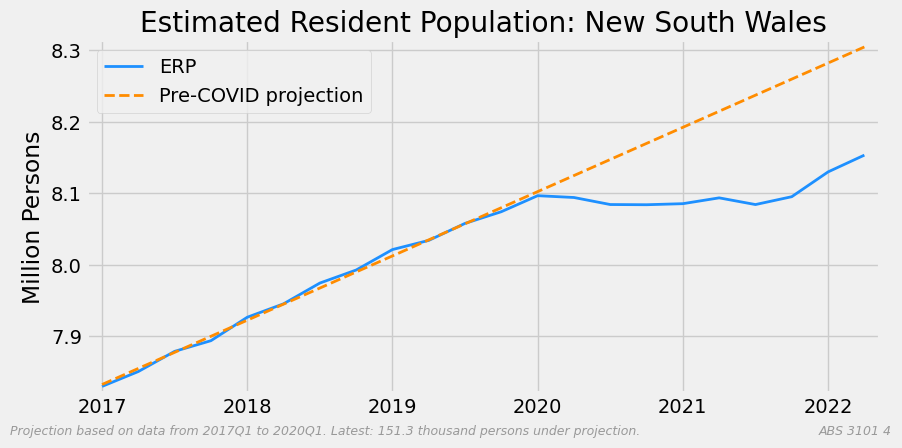

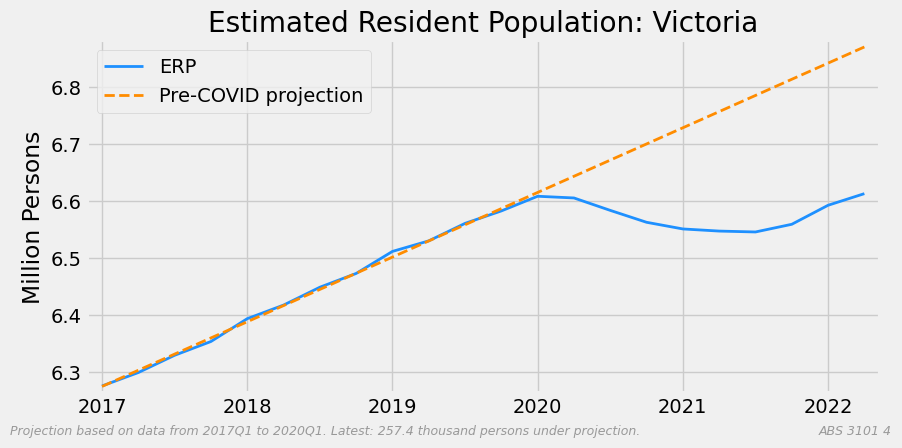

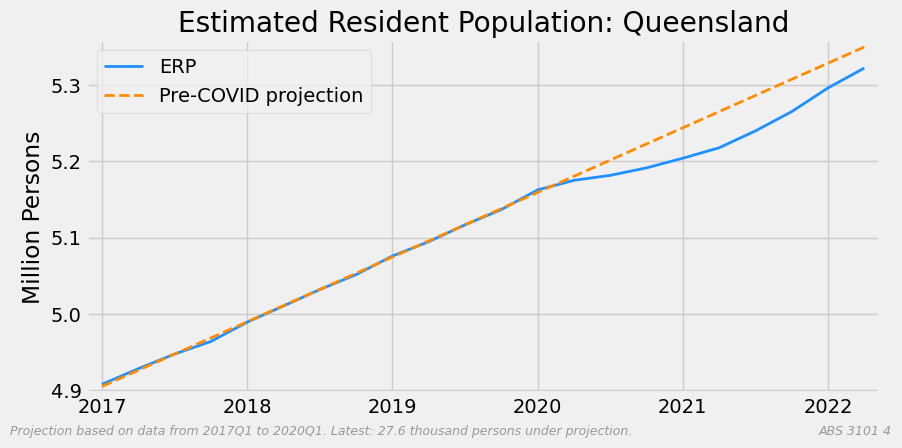

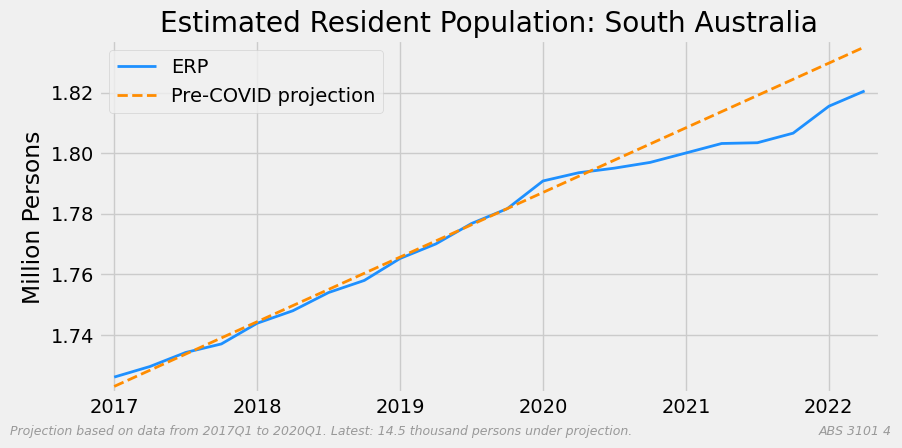

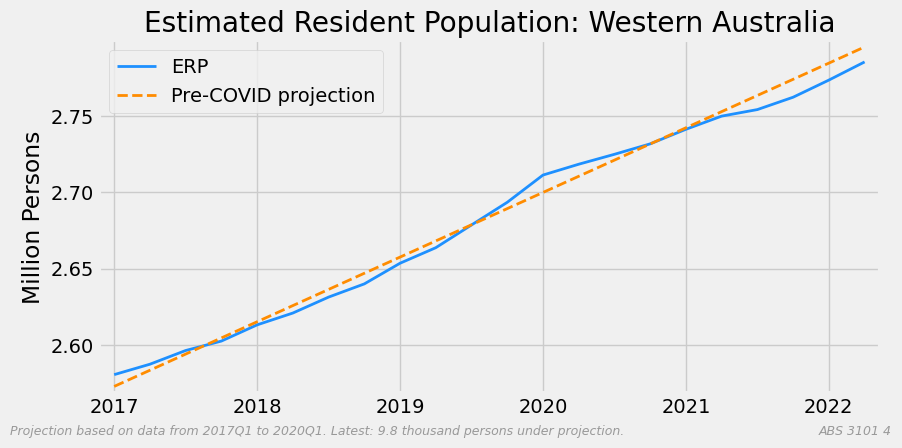

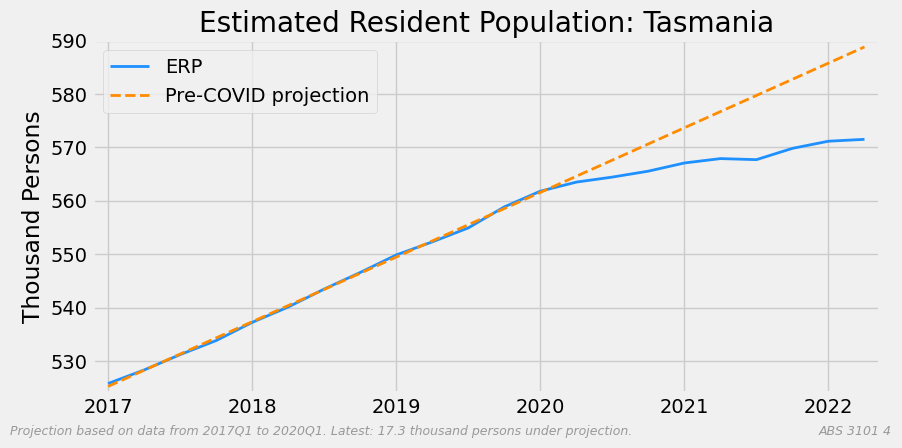

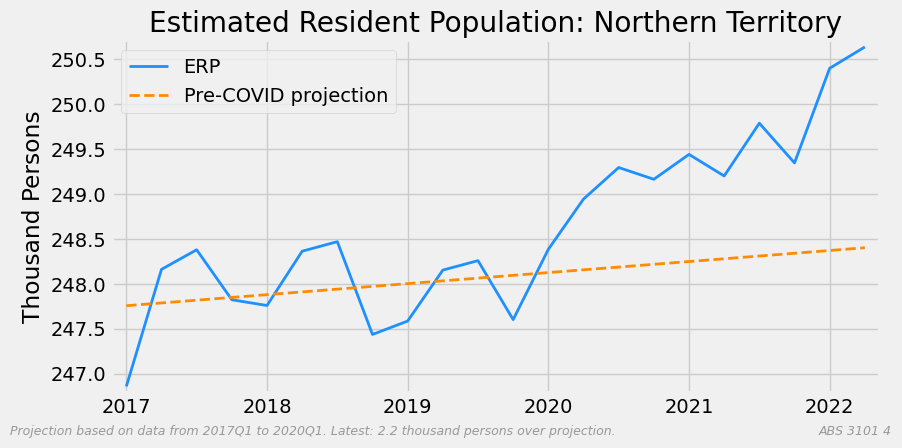

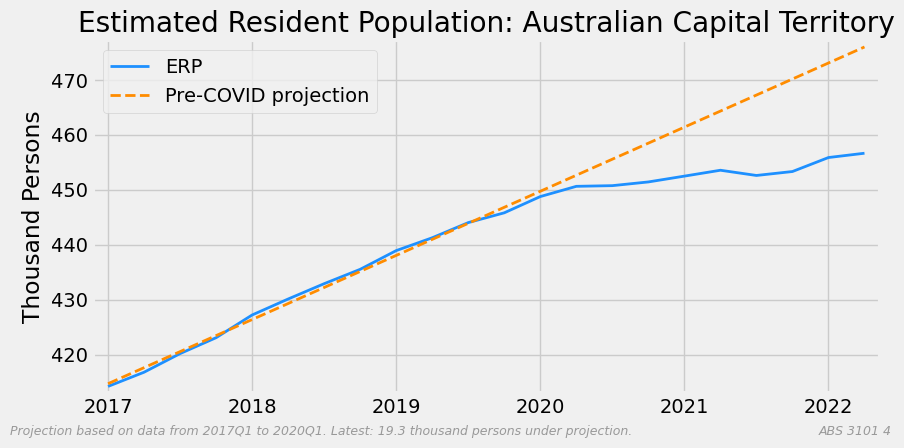

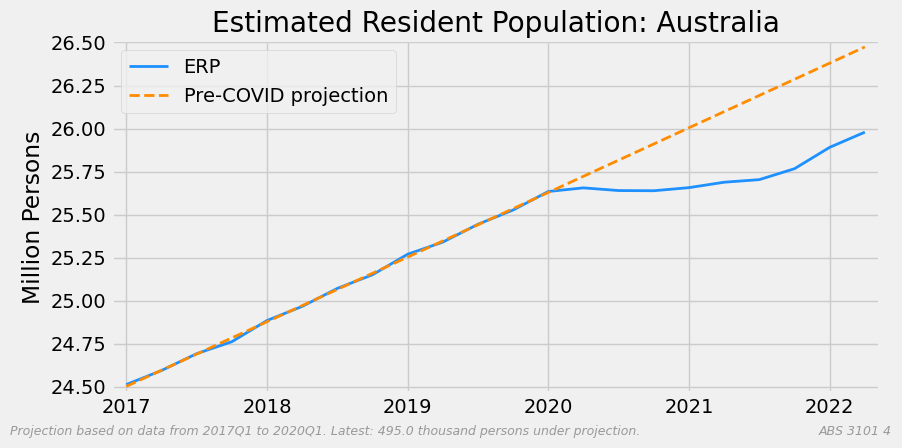

In [5]:
table = '4'
erp_df = erp_dict[table]

states = erp_meta.loc[
    (erp_meta[table_col] == table)
    & (erp_meta[did_col].str.contains(erp_phrase)),
    did_col
].str.replace(erp_phrase, '').str.replace(' ;', '').str.strip().to_list()

for state in states:
    
    # get relevant data series
    selector = {
        table: table_col,
        erp_phrase: did_col,
        f';  {state} ;': did_col, # Australia, South Australia, etc.
    }
    id, units = find_id(erp_meta, selector, verbose=False)
    series = erp_df[id]
    series.index = pd.PeriodIndex(series.index, freq='Q')
    units = 'Number Persons' if units == 'Persons' else units
    series, units = recalibrate_series(series, units)

    # plot complete series
    ax = series.plot(lw=2)
    title = f'Estimated Resident Population: {state}'
    finalise_plot(
        ax, title, 
        f'{units}', 
        '', CHART_DIR,
        rfooter=f'{source} {table}',
        #show=True,
    )
    
    # plot a post-2017 series, with a projection line
    PRE_COVID = pd.Period('2017-01-01', freq='Q')
    recent = series[series.index >= PRE_COVID]
    LIN_REGRESS = pd.Period('2020-01-01', freq='Q')
    projection = get_projection(recent, LIN_REGRESS)
    
    ax = recent.plot(lw=2, c="dodgerblue", label='ERP')
    ax = projection.plot(lw=2, c="darkorange", ls='--', label='Pre-COVID projection')
    ax.legend(loc='best')
    title = f'Estimated Resident Population: {state}'
    
    diff = recent.iloc[-1] - projection.iloc[-1]
    abs_diff = abs(diff)
    abs_diff, diff_units = recalibrate_value(abs_diff, units)
    diff_units = diff_units.replace('Number ', '')
    under = 'under' if diff < 0 else 'over'
    diff_phrase = f'Latest: {abs_diff:0.1f} {diff_units.lower()} {under} projection.'
    
    finalise_plot(
        ax, title, 
        f'{units}', 
        '-recent', CHART_DIR,
        rfooter=f'{source} {table}',
        lfooter=f'Projection based on data from {PRE_COVID} to {LIN_REGRESS}. {diff_phrase}',
        show=True,
    )

## Finished

In [6]:
print('Finished')

Finished
